<a href="https://colab.research.google.com/github/gusmarlaj/Machine_Learning_Ideas/blob/master/Airbnb_prices_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Airbnb price prediction**

About Dataset: This dataset describes the listing activity and metrics in NYC, NY for 2019. This data file includes all needed information to find out more about hosts, geographical availability, necessary metrics to make predictions and draw conclusions.

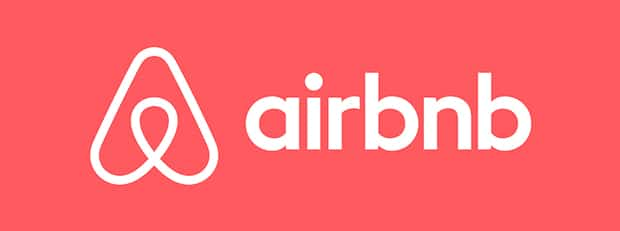

Source: New York City Airbnb Open Data



In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn import ensemble, tree, linear_model
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet


import warnings

# Ignore future warnings and user warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Understanding the data

In [6]:
df = pd.read_csv('AB_NYC_2019.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
# Statistical Summary of categorical columns
desc = pd.DataFrame(index = list(df))
desc['type'] = df.dtypes
desc['count'] = df.count()
desc['nunique'] = df.nunique()
desc['%unique'] = desc['nunique'] /len(df) * 100
desc['null'] = df.isnull().sum()
desc['%null'] = desc['null'] / len(df) * 100
desc = pd.concat([desc,df.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
id,int64,48895,48895,100.000000,0,0.000000,19017143.236180,10983108.385610,2539.000000,9471945.000000,19677284.000000,29152178.500000,36487245.000000
host_id,int64,48895,37457,76.607015,0,0.000000,67620010.646610,78610967.032667,2438.000000,7822033.000000,30793816.000000,107434423.000000,274321313.000000
price,int64,48895,674,1.378464,0,0.000000,152.720687,240.154170,0.000000,69.000000,106.000000,175.000000,10000.000000
minimum_nights,int64,48895,109,0.222927,0,0.000000,7.029962,20.510550,1.000000,1.000000,3.000000,5.000000,1250.000000
number_of_reviews,int64,48895,394,0.805808,0,0.000000,23.274466,44.550582,0.000000,1.000000,5.000000,24.000000,629.000000
calculated_host_listings_count,int64,48895,47,0.096124,0,0.000000,7.143982,32.952519,1.000000,1.000000,1.000000,2.000000,327.000000
availability_365,int64,48895,366,0.748543,0,0.000000,112.781327,131.622289,0.000000,0.000000,45.000000,227.000000,365.000000
latitude,float64,48895,19048,38.956949,0,0.000000,40.728949,0.054530,40.499790,40.690100,40.723070,40.763115,40.913060
longitude,float64,48895,14718,30.101237,0,0.000000,-73.952170,0.046157,-74.244420,-73.983070,-73.955680,-73.936275,-73.712990
reviews_per_month,float64,38843,937,1.916351,10052,20.558339,1.373221,1.680442,0.010000,0.190000,0.720000,2.020000,58.500000


##    Statistical Summary

    ID: A unique identifier for each listing, with 48,895 entries and no missing values. The mean ID is approximately 19,017,143, with a standard deviation of 10,983,108.

    Host ID: Identifies the host of each listing, with 37,457 unique hosts. There are no missing values. The mean host ID is around 67,620,011, with a standard deviation of 78,610,967.

    Price: The price of each listing, ranging from 0 to 10,000. The mean price is $152.72, with a standard deviation of $240.15.

    Minimum Nights: The minimum number of nights for booking, with an average of 7.03 nights and a standard deviation of 20.51 nights.

    Number of Reviews: Indicates how many reviews each listing has received, with an average of 23.27 reviews and a standard deviation of 44.55.

    Calculated Host Listings Count: Shows the number of listings each host has, with an average of 7.14 and a standard deviation of 32.95.

    Availability 365: The availability of the listing throughout the year, with an average of 112.78 days available and a standard deviation of 131.62 days.

    Latitude & Longitude: Geographic coordinates of each listing, with latitude ranging from approximately 40.5 to 40.91 and longitude ranging from approximately -74.24 to -73.71.

    Reviews per Month: The average number of reviews per month, with a mean of 1.37 and a standard deviation of 1.68.

    Neighbourhood Group, Neighbourhood, Room Type, Name, Host Name, Last Review: These are categorical variables with various levels and percentages of uniqueness, as well as missing values.

In [8]:
df.shape

(48895, 16)

## Data pre-processing

**Duplicate values**

In [9]:
print('Number of duplicate values in dataframe are :',df.duplicated().sum())

Number of duplicate values in dataframe are : 0


**Identifying missing values**

In [10]:
def check_missing_values(df):
    missing_columns = [col for col in df.columns if df[col].isnull().any()]
    missingvalues_count =df.isna().sum()
    missingValues_df = pd.DataFrame(missingvalues_count.rename('Missing Values')).loc[missingvalues_count.ne(0)]
    missingValues_df['Percentage'] = missingValues_df['Missing Values'] * 100 / df.shape[0]
    return missingValues_df

In [11]:
df_missing_values = check_missing_values(df)
print(df_missing_values.sort_values(by='Missing Values', ascending=False))

                   Missing Values  Percentage
last_review                 10052   20.558339
reviews_per_month           10052   20.558339
host_name                      21    0.042949
name                           16    0.032723


**Remove unnecessary columns**

In [12]:
df.drop(['name','id','host_name','last_review'], axis=1, inplace=True)

**Handling missing data**

In [13]:
#fill null values in reviews_per_month by 0
df['reviews_per_month'].fillna(0, inplace=True)

In [14]:
df.isnull().sum()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [15]:
df.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


## Data Visualization

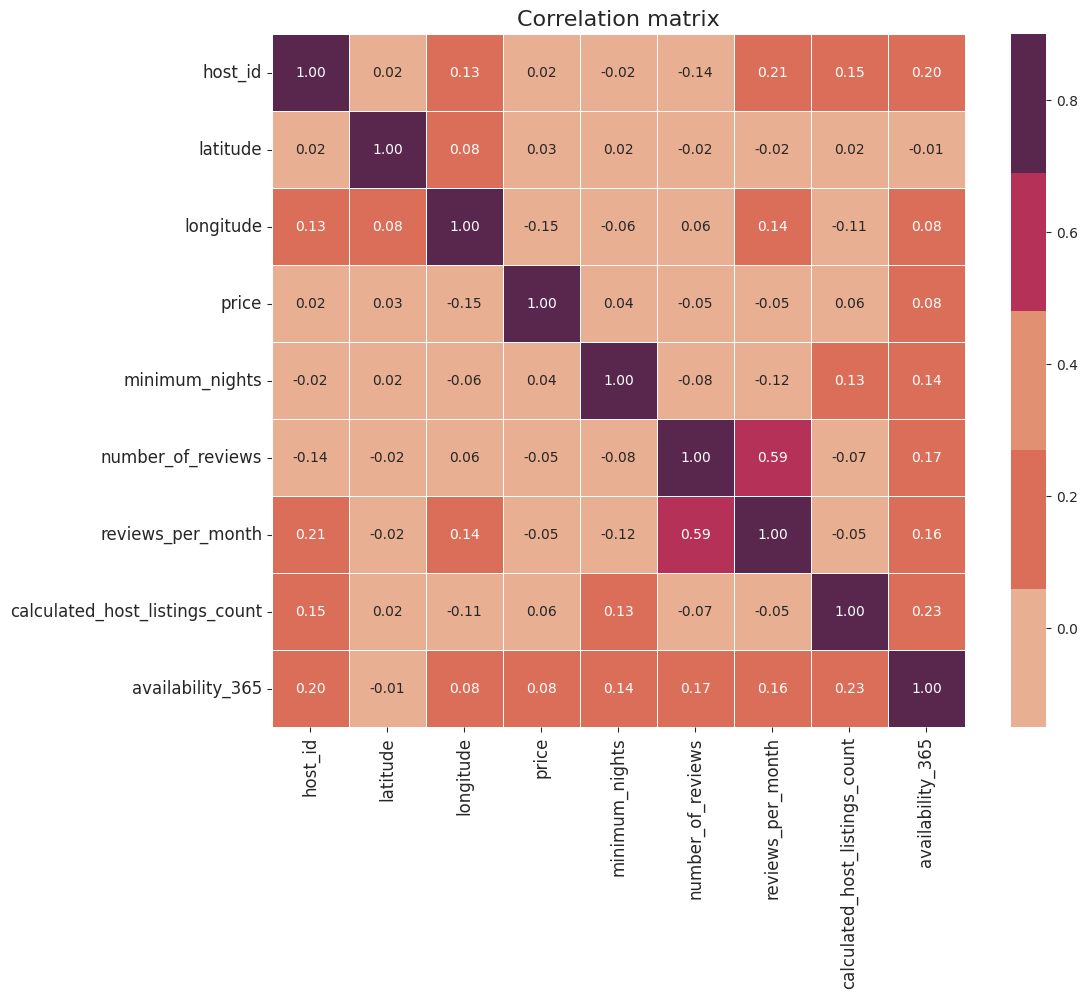

In [28]:
# Correlation between variables

airbnb_colors = ['#e8af92', '#db6e59','#e29072', '#b53158','#59274e']

corrmat = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap=sns.color_palette(palette=airbnb_colors), annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Neighbourhood

In [18]:
# Neighbourhood Group
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

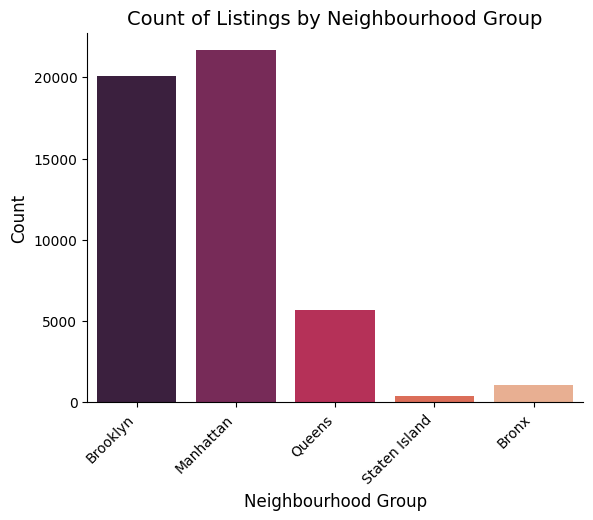

In [19]:
# Create the countplot with Airbnb colors
ax = sns.countplot(x="neighbourhood_group", data=df, palette="rocket")
# Add labels and title
ax.set_xlabel("Neighbourhood Group", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Count of Listings by Neighbourhood Group", fontsize=14)
# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
# Remove spines
sns.despine()
# Show plot
plt.show()

In [20]:
#neighbourhood

df2=pd.DataFrame(df['neighbourhood'].value_counts()).reset_index().rename(columns={'index': 'neighbourhood','neighbourhood':'count'})
df2

,neighbourhood,count
0,Williamsburg,3920
1,Bedford-Stuyvesant,3714
2,Harlem,2658
3,Bushwick,2465
4,Upper West Side,1971
...,...,...
216,Fort Wadsworth,1
217,Richmondtown,1
218,New Dorp,1
219,Rossville,1


In [21]:
# Number of rentals per neighbourhood
airbnb_gradient_colors = ['#59274e', '#b53158', '#e29072']  # Select three distinct colors from the Airbnb color scheme
fig2 = go.Figure(go.Bar(
    x=df2['neighbourhood'],
    y=df2['count'],
    marker={'color': df2['count'], 'colorscale': airbnb_gradient_colors},  # Use the defined colorscale
    text=df2['count'],
    textposition="outside",
))

fig2.update_layout(
    xaxis_title="Neighbourhood",
    yaxis_title="Count",
)

fig2.show()

Room Type

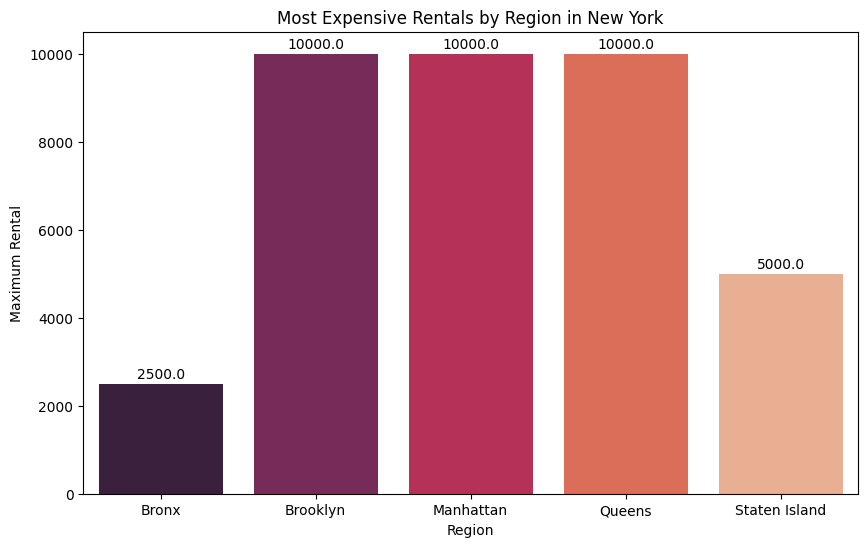

In [22]:
# Most Expensive Rentals by Region in New York

# Group the data by region type and calculate the maximum rental prices
max_rental_by_region = df.loc[:, ['neighbourhood_group', 'price']].groupby('neighbourhood_group').max()

# Convert the values to integers
max_rental_by_region = max_rental_by_region.astype(int)

# Reset the index to make 'neighbourhood_group' a column again
max_rental_by_region.reset_index(inplace=True)

# Rename the columns for better understanding
max_rental_by_region.columns = ['Region', 'Maximum Rental']

# Seaborn barplot for maximum rental prices by region
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Region', y='Maximum Rental', data=max_rental_by_region, palette="rocket")
plt.title('Most Expensive Rentals by Region in New York')
plt.xlabel('Region')
plt.ylabel('Maximum Rental')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 7), textcoords='offset points')
plt.show()

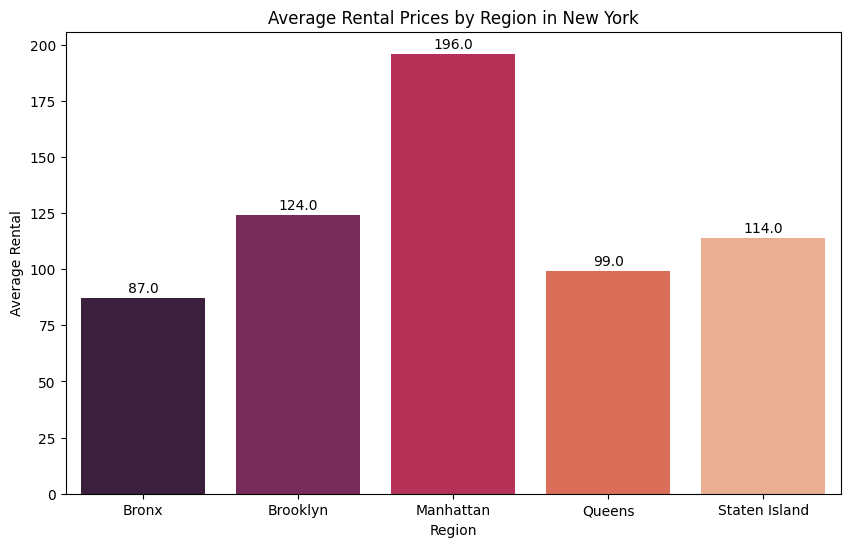

In [23]:
# Average Rental Prices by Region in New York

# Group the data by region type and calculate the average rental prices
average_rental_by_region = df.loc[:, ['neighbourhood_group', 'price']].groupby('neighbourhood_group').mean()

# Convert the values to integers
average_rental_by_region = average_rental_by_region.astype(int)

# Reset the index to make 'neighbourhood_group' a column again
average_rental_by_region.reset_index(inplace=True)

# Rename the columns for better understanding
average_rental_by_region.columns = ['Region', 'Average Rental']


# Seaborn barplot for average rental prices by region
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Region', y='Average Rental', data=average_rental_by_region, palette="rocket")
plt.title('Average Rental Prices by Region in New York')
plt.xlabel('Region')
plt.ylabel('Average Rental')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 7), textcoords='offset points')
plt.show()

Neighbourhood vs availability of room

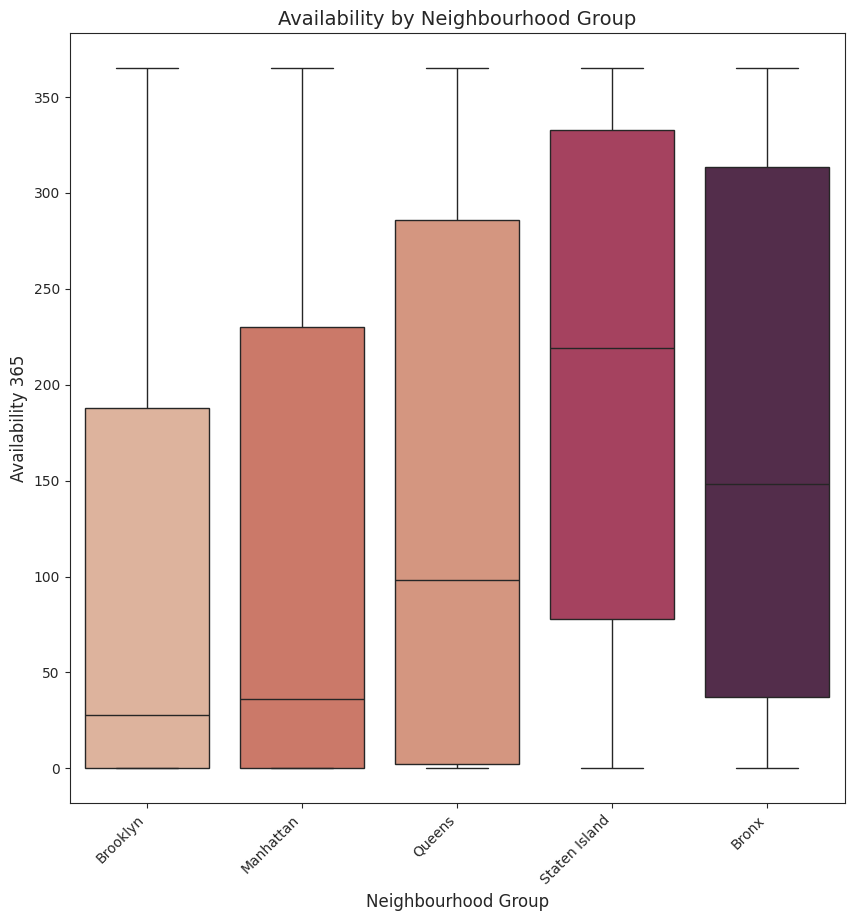

In [30]:
# Define the Airbnb colors palette
airbnb_colors = ['#e8af92', '#db6e59','#e29072', '#b53158','#59274e']

# Set the style
sns.set_style("ticks")

# Create the boxplot with the defined palette
plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=df, x='neighbourhood_group', y='availability_365', palette=airbnb_colors)

# Add labels and title
ax.set_xlabel("Neighbourhood Group", fontsize=12)
ax.set_ylabel("Availability 365", fontsize=12)
ax.set_title("Availability by Neighbourhood Group", fontsize=14)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Show the plot
plt.show()


Room Type

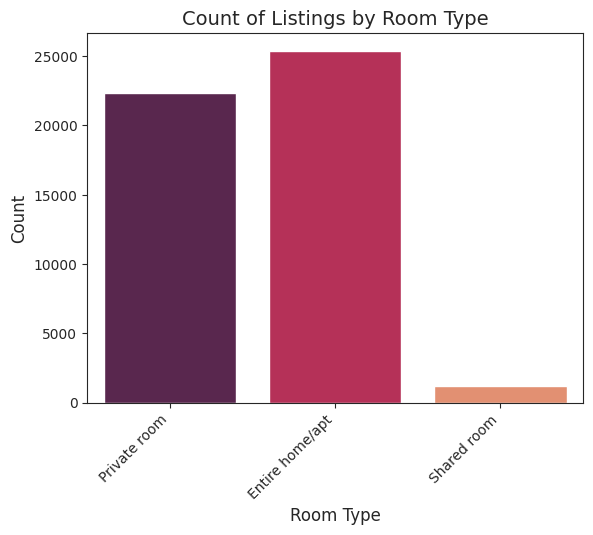

In [25]:
# Create the countplot with the specified colors
ax = sns.countplot(x="room_type", data=df, palette="rocket")
# Add labels and title
ax.set_xlabel("Room Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Count of Listings by Room Type", fontsize=14)
# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# Show plot
plt.show()


Room type vs availability

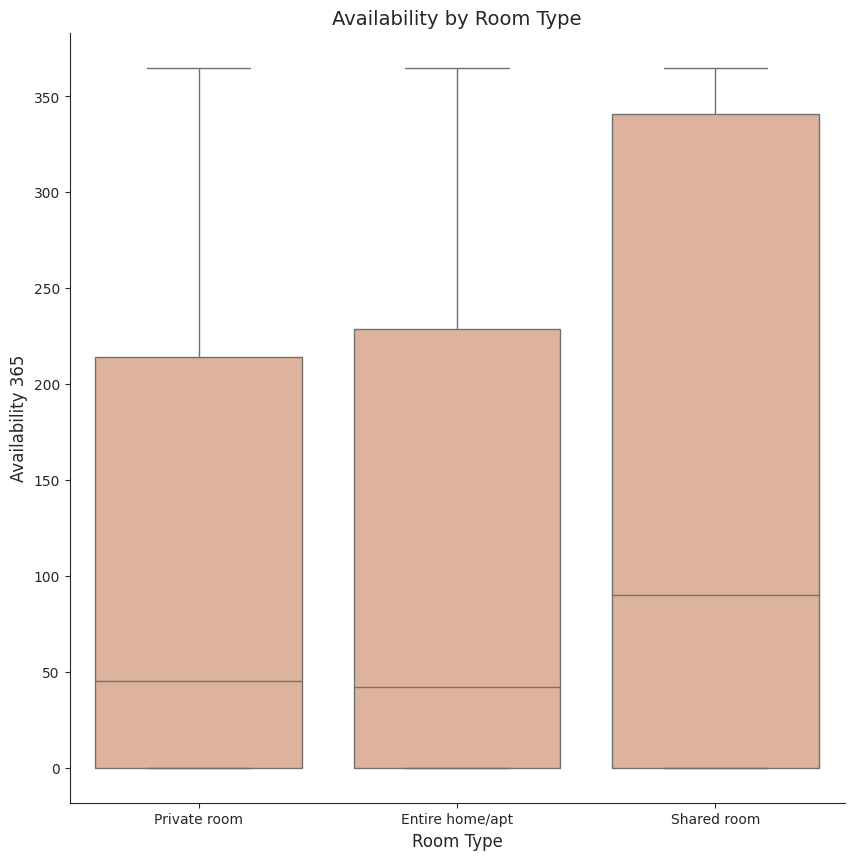

In [31]:
sns.set_palette(airbnb_colors)
# Define the Airbnb colors palette
airbnb_colors = ['#e8af92', '#db6e59','#e29072', '#b53158','#59274e']

# Set the style
# Create the boxplot
plt.figure(figsize=(10, 10))
ax = sns.boxplot(data=df, x='room_type', y='availability_365')
# Add labels and title
ax.set_xlabel("Room Type", fontsize=12)
ax.set_ylabel("Availability 365", fontsize=12)
ax.set_title("Availability by Room Type", fontsize=14)
# Remove top and right spines
sns.despine()
# Show plot
plt.show()

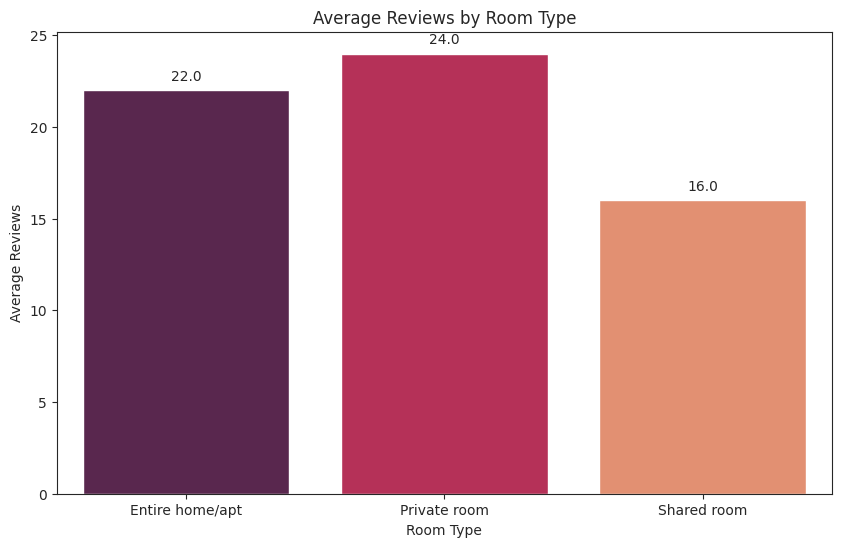

In [32]:
# Average Reviews by Room Type

# Group the data by room type and calculate the average number of reviews
average_reviews_by_type = df.loc[:, ['number_of_reviews', 'room_type']].groupby('room_type').mean()

# Convert the values to integers
average_reviews_by_type = average_reviews_by_type.astype(int)

# Reset the index to make 'room_type' a column again
average_reviews_by_type.reset_index(inplace=True)

# Rename the columns for better understanding
average_reviews_by_type.columns = ['Room Type', 'Average Reviews']

# Seaborn barplot for average reviews by room type with data labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Room Type', y='Average Reviews', data=average_reviews_by_type, palette="rocket")
plt.title('Average Reviews by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Reviews')

# Add data labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

Data by region and room type

In [33]:
import plotly.express as px

# Define custom color palette (shades of pink and purple)
custom_colors = {'Entire home/apt': '#59274e', 'Private room': '#b53158', 'Shared room': '#e29072'}

# Group the data by region and room type and calculate the maximum rental value
max_value_region_type = df.loc[:, ['neighbourhood_group', 'room_type', 'price']].groupby(['neighbourhood_group', 'room_type']).max().reset_index()

# Convert the values to integers
max_value_region_type['price'] = max_value_region_type['price'].astype(int)

# Rename the columns for better understanding
max_value_region_type.columns = ['Region', 'Type', 'Maximum Value']

# Create bar plot with custom colors
fig = px.bar(max_value_region_type,
             x='Maximum Value',
             y='Region',
             color='Type',
             orientation='h',
             color_discrete_map=custom_colors,  # Use custom colors
             labels={'Maximum Value':'Maximum Rental Price', 'Region':'Region', 'Type':'Room Type'},
             title='Maximum Rental Price by Region and Room Type in New York City')

# Add data labels inside bars
fig.update_traces(texttemplate='%{x:.0f}', textposition='inside')

# Show plot
fig.show()


Owners

In [34]:
import plotly.express as px

# Define custom color palette (shades of pink and purple)
custom_colors = {'Bronx': '#59274e', 'Brooklyn': '#772b58', 'Manhattan': '#b53158', 'Queens': '#db6e59', 'Staten Island': '#e8af92'}

# Number of Owners by Region
owners_by_region = df.loc[:, ['host_id', 'neighbourhood_group']].groupby('neighbourhood_group').nunique()

# Create the bar chart with Plotly Express
fig = px.bar(owners_by_region.reset_index(),
             x='neighbourhood_group',
             y='host_id',
             title='Number of Unique Owners by Region',
             labels={'host_id':'Number of Owners', 'neighbourhood_group':'Region'},
             color='neighbourhood_group',  # Use neighbourhood_group for color mapping
             color_discrete_map=custom_colors,  # Use custom color palette
             template='plotly_white')

# Add data labels
fig.update_traces(texttemplate='%{y:.0f}', textposition='outside')

# Remove the y-axis
fig.update_yaxes(showticklabels=False)

# Show the chart
fig.show()


## Maps

Maps of New York

Apartments located in the most expensive region of New York

In [35]:
import folium as fl

# Select columns and sample 50 rows
columns = ['neighbourhood_group', 'room_type', 'latitude', 'longitude']
data_plot = df.loc[:, columns].sample(50, random_state=1)

# Calculate average location
average_location = [data_plot['latitude'].mean(), data_plot['longitude'].mean()]

# Create a new column called 'color'
data_plot['color'] = 'NA'

# Define conditions for each room type
rows_private_room = data_plot['room_type'] == 'Private room'
rows_entire_apt = data_plot['room_type'] == 'Entire home/apt'
rows_shared_room = data_plot['room_type'] == 'Shared room'

# Assign colors based on room type
data_plot.loc[rows_private_room, 'color'] = 'darkgreen'
data_plot.loc[rows_entire_apt, 'color'] = 'darkred'
data_plot.loc[rows_shared_room, 'color'] = 'purple'

# Draw map
map_sample = fl.Map(location=average_location, zoom_start=14, control_scale=True)

# Add markers to the map
for index, location_info in data_plot.iterrows():
    fl.Marker(
        [location_info['latitude'], location_info['longitude']],
        popup=location_info[['neighbourhood_group', 'room_type']].to_string(),
        icon=fl.Icon(color=location_info['color'])
    ).add_to(map_sample)

# Display the map
map_sample



In [36]:
import plotly.express as px

# Set up Mapbox token
px.set_mapbox_access_token('your_mapbox_token')

# Create scatter plot with New York City map as base
fig3 = px.scatter_mapbox(df,
                          lat='latitude',
                          lon='longitude',
                          color='neighbourhood_group',
                          zoom=10)

# Update layout with axis titles
fig3.update_layout(
    mapbox_style="carto-positron",  # Mapbox style
    mapbox_zoom=10,  # Initial zoom level
    mapbox_center={"lat": 40.730610, "lon": -73.935242},  # Centered in New York
    margin={"r":0,"t":0,"l":0,"b":0},  # Zero margin
    xaxis_title="Longitude",
    yaxis_title="Latitude"
)

# Show the plot
fig3.show()


## Regression Analysis

-Linear Regression

-Decision Tree Regression

-Random Forest Regression-


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

In [41]:
#Drop columns

df.drop(['host_id','latitude','longitude','neighbourhood','number_of_reviews','reviews_per_month'], axis=1, inplace=True)
#examing the changes
df.head(5)

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,149,1,6,365
1,Manhattan,Entire home/apt,225,1,2,355
2,Manhattan,Private room,150,3,1,365
3,Brooklyn,Entire home/apt,89,1,1,194
4,Manhattan,Entire home/apt,80,10,1,0


In [42]:
#Encode the input Variables
def Encode(df):
    for column in df.columns[df.columns.isin(['neighbourhood_group', 'room_type'])]:
        df[column] = df[column].factorize()[0]
    return df

airbnb_en = Encode(df.copy())

In [43]:
airbnb_en.head(15)

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,0,0,149,1,6,365
1,1,1,225,1,2,355
2,1,0,150,3,1,365
3,0,1,89,1,1,194
4,1,1,80,10,1,0
5,1,1,200,3,1,129
6,0,0,60,45,1,0
7,1,0,79,2,1,220
8,1,0,79,2,1,0
9,1,1,150,1,4,188


In [45]:
#Defining the independent variables and dependent variables
x = airbnb_en.iloc[:,[0,1,3,4,5]]
y = airbnb_en['price']
#Getting Test and Training Set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=353)
x_train.head()
y_train.head()

17736    125
24351    101
10069    189
11679    145
16315    120
Name: price, dtype: int64

In [46]:
x_train.shape

(44005, 5)

Model 1: linear Regression

In [47]:
#Prepare a Linear Regression Model
reg=LinearRegression()
reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.07480306392848757

Model 2: Decision Tree Regression

In [49]:
from sklearn.tree import DecisionTreeRegressor
DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(x_train,y_train)

print('R-squared score (training): {:.3f}'.format(DTree.score(x_train, y_train)))
print('R-squared score (test): {:.3f}'.format(DTree.score(x_test, y_test)))

R-squared score (training): 0.298
R-squared score (test): 0.253


Model 3: Lasso Regression

In [50]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10,max_iter = 10000)
lasso.fit(x_train, y_train)

print('R-squared score (training): {:.3f}'.format(lasso.score(x_train, y_train)))
print('R-squared score (test): {:.3f}'.format(lasso.score(x_test, y_test)))

R-squared score (training): 0.044
R-squared score (test): 0.036


Model 4: Random forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestClassifier

regressor = RandomForestClassifier()
regressor.fit(x_train, y_train)

print('R-squared score (training): {:.3f}'.format(regressor.score(x_train, y_train)))
print('R-squared score (test): {:.3f}'.format(regressor.score(x_test, y_test)))

Model 5: Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(x_train, y_train)

y_pred=ridge.predict(x_test)

print('R-squared train score: {:.3f}'.format(ridge.score(x_train, y_train)))
print('R-squared test score: {:.3f}'.format(ridge.score(x_test, y_test)))

Overall, based on the R-squared scores:

**Linear Regression, Ridge Regression, and Lasso Regression** appear to underfit the data.

Decision Tree Regressor performs better than the linear models but may still have room for improvement.

Random Forest Regressor performs well on the training data but shows signs of overfitting when applied to the test data. Regularization techniques or hyperparameter tuning may help mitigate overfitting in the Random Forest model.

References

https://www.kaggle.com/code/chirag9073/airbnb-analysis-visualization-and-prediction

https://www.kaggle.com/code/yashvi/airbnb-price-prediction